<font size='6'><b>Demo multimarginal OT</b></font>

# init

In [2]:
import sys, os, h5py, bz2, pylab as plt, importlib, itertools
from tqdm.auto import tqdm, trange
from collections import OrderedDict
from IPython.display import set_matplotlib_formats
import seaborn
from ipywidgets import interactive, fixed
set_matplotlib_formats('retina')
plt.style.use('dark_background')
# plt.style.use('default')
%pylab inline
%load_ext autoreload
%autoreload 2
if 'notebooks' in os.getcwd(): os.chdir('..')
print(os.getcwd())
import matplotlib as mpl
mpl.rcParams.update({"axes.grid" : True})
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linestyle'] = '--'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/tomaszk/Archive/projects/230921_samurai/038_otentropic


/var/folders/96/4c5n4tpd02l_82z2ppsmr5_40000gn/T/ipykernel_63726/2036380350.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')
/Users/tomaszk/pyvenv/miniconda3/envs/tfm1231030/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['interactive', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# toy data

In [3]:
def plot_scenario(x, yo, B, B_others=None):

    xlim = [-1,1]

    colors = seaborn.color_palette('tab10', B.shape[1])
    ylim = [0, max(np.max(yo), np.max(B))*1.1]
    nx, ny = 1,2 ; figsize=4; fig, ax  = plt.subplots(nx, ny, figsize=(ny * figsize * 1.25, nx * figsize), squeeze=False); axl=ax.ravel(); axc=ax[0,0];  fig.set_label(' ')
    axl[0].plot(x, yo, c='red')
    axl[0].set(title='measured', ylim=ylim, xlim=xlim, xlabel='x')
    for i, b in enumerate(B.T):
        axl[1].plot(x, b, label=i, color=colors[i], lw=3);
    axl[1].legend()
    

    if B_others is not None:
        for i, B_ in enumerate(B_others):
            axl[1].plot(x, B_, colors[i], color=colors[i], lw=1)
    axl[1].set(title='basis', ylim=ylim, xlim=xlim, xlabel='x')

In [4]:
def gaussian_normalized(a, x, sig):
    g = gauss(a, x, sig)
    g = a*g/np.sum(g)
    return g

In [5]:
sig = 0.05
gauss = lambda a, mu, sig: a*np.exp(-(x-mu)**2/sig**2)
renorm = lambda y: y/np.trapz(y, x=x)

In [22]:
x = np.linspace(-1,1,100)
y0 = gaussian_normalized(1, 0, 0.2)
y1 = gaussian_normalized(0.5, -0.5, 0.2) + gaussian_normalized(0.5, 0.5, 0.2)
y2 = gaussian_normalized(1/3, -0.7, 0.1) + gaussian_normalized(1/3, 0., 0.1) + gaussian_normalized(1/3, 0.7, 0.1)

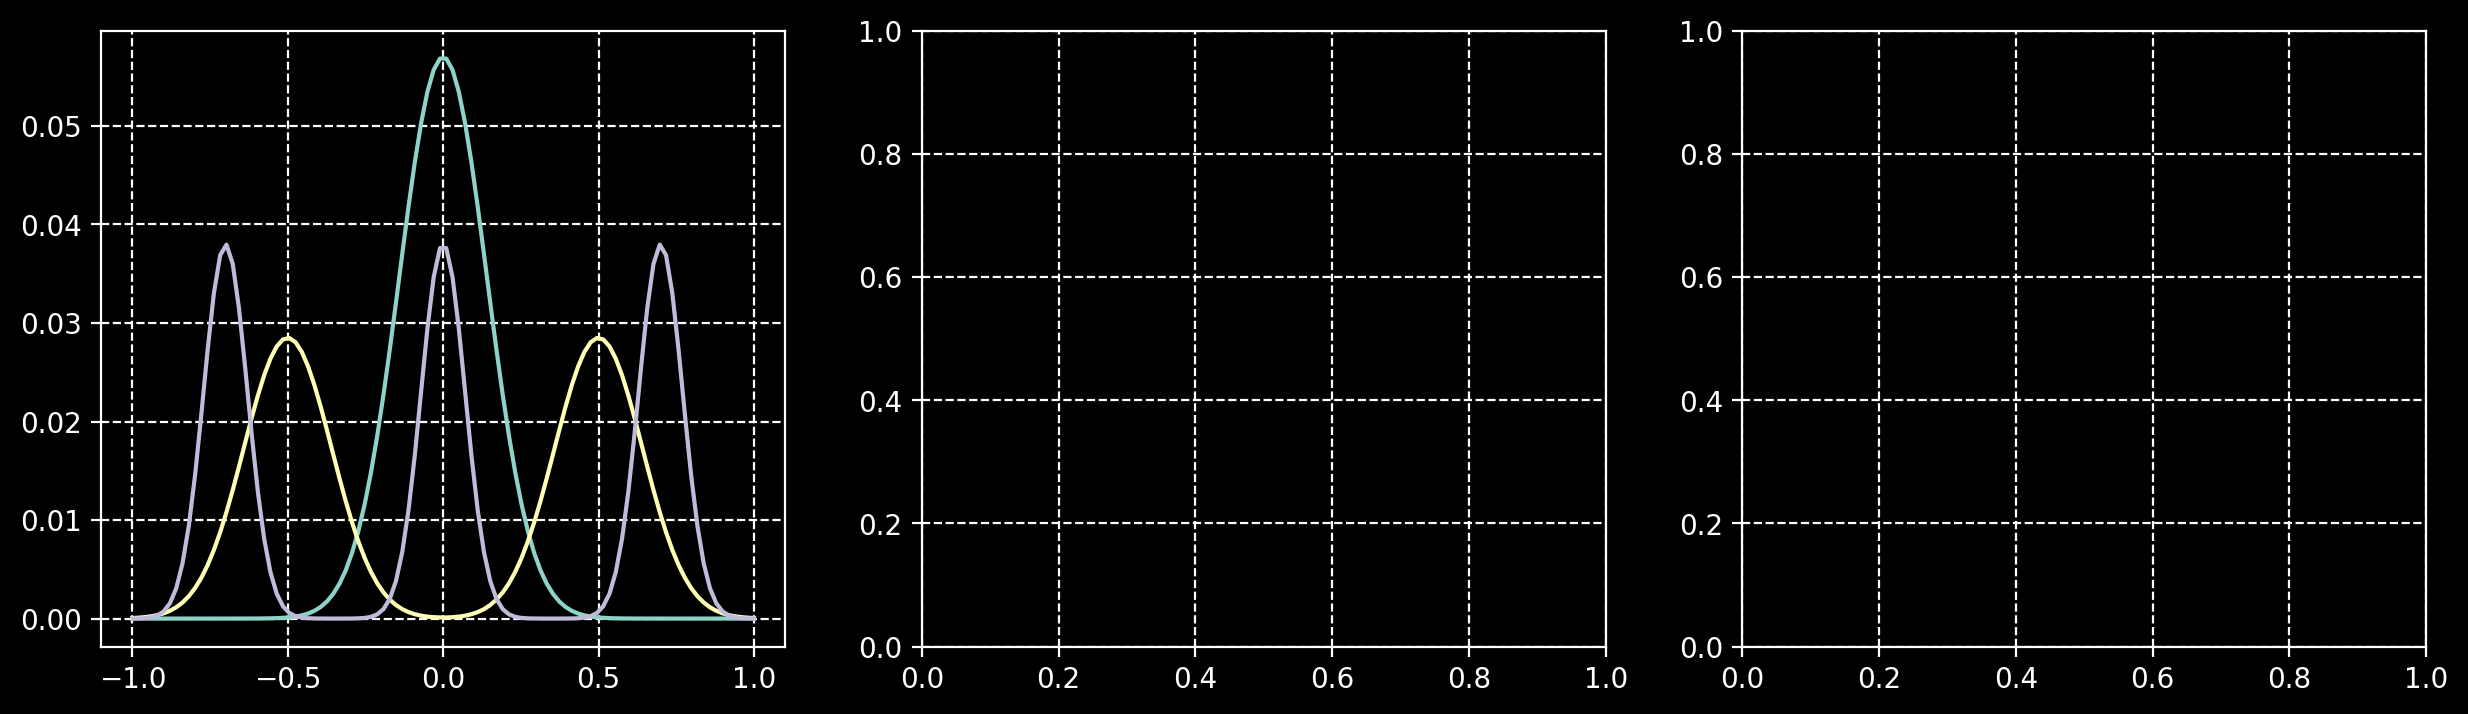

In [23]:
nx, ny = 1, 3; figsize=4; fig, ax  = plt.subplots(nx, ny, figsize=(ny * figsize * 1.25, nx * figsize), squeeze=False); axl=ax.ravel(); axc=ax[0,0];  fig.set_label(' ')
axl[0].plot(x, y0)
axl[0].plot(x, y1)
axl[0].plot(x, y2)

In [34]:
x0, x1, x2 = np.meshgrid(x, x, x)

In [35]:
C = (x0-x1)**2 + (x1-x2)**2 + (x0-x2)**2

In [46]:
def multimarginal_ot(y0, y1, y2, C, eps=1e-2, num_iter=100):

    K = exp(-C/eps)
    a0 = np.ones(len(y0))
    a1 = np.ones(len(y1))
    a2 = np.ones(len(y2))

    for i in range(num_iter):

        a0 = y0/np.einsum('ijk,j,k->i', K, a1, a2)
        a1 = y1/np.einsum('ijk,i,k->j', K, a0, a2)
        a2 = y2/np.einsum('ijk,i,j->k', K, a0, a1)

    return K * a0.reshape(-1,1,1) * a1.reshape(1,-1,1) * a2.reshape(1,1,-1)

        
    

In [47]:
K = multimarginal_ot(y0, y1, y2, C, eps=1e-2, num_iter=100)

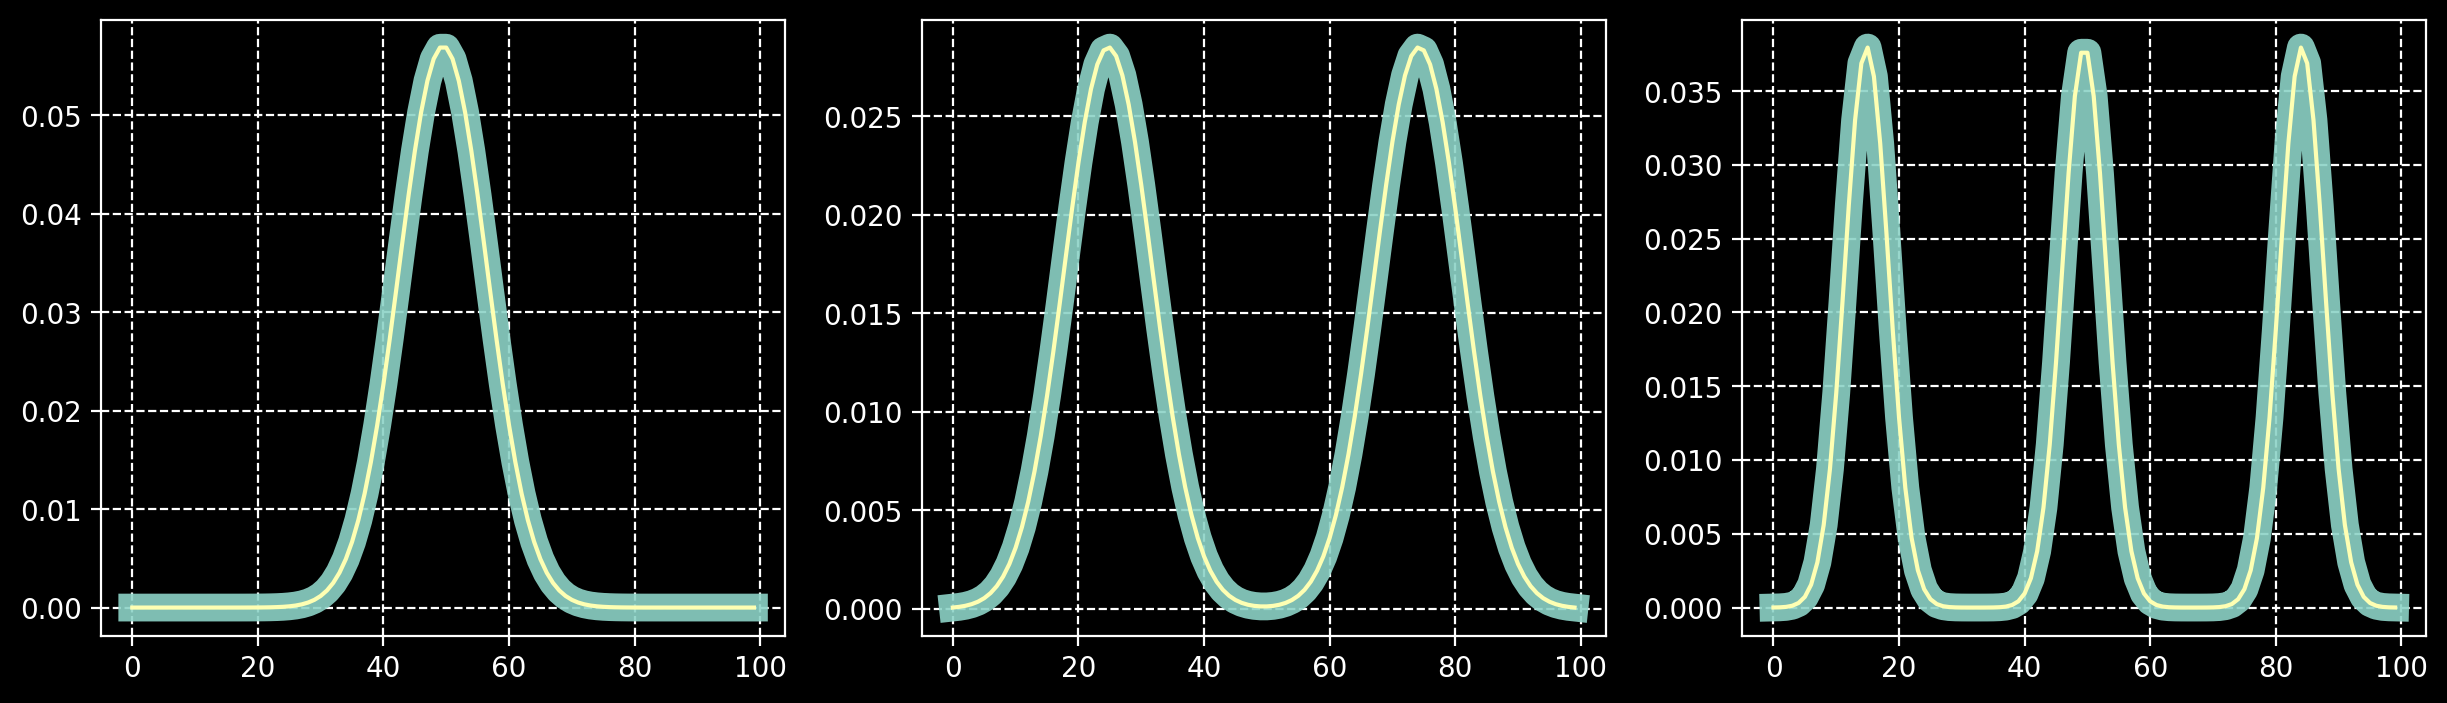

In [63]:
nx, ny = 1, 3; figsize=4; fig, ax  = plt.subplots(nx, ny, figsize=(ny * figsize * 1.25, nx * figsize), squeeze=False); axl=ax.ravel(); axc=ax[0,0];  fig.set_label(' ')
axl[0].plot(y0, lw=10, alpha=0.9)
axl[0].plot(K.sum(axis=(1,2)))
axl[1].plot(y1, lw=10, alpha=0.9)
axl[1].plot(K.sum(axis=(0,2)))
axl[2].plot(y2, lw=10, alpha=0.9)
axl[2].plot(K.sum(axis=(0,1)))

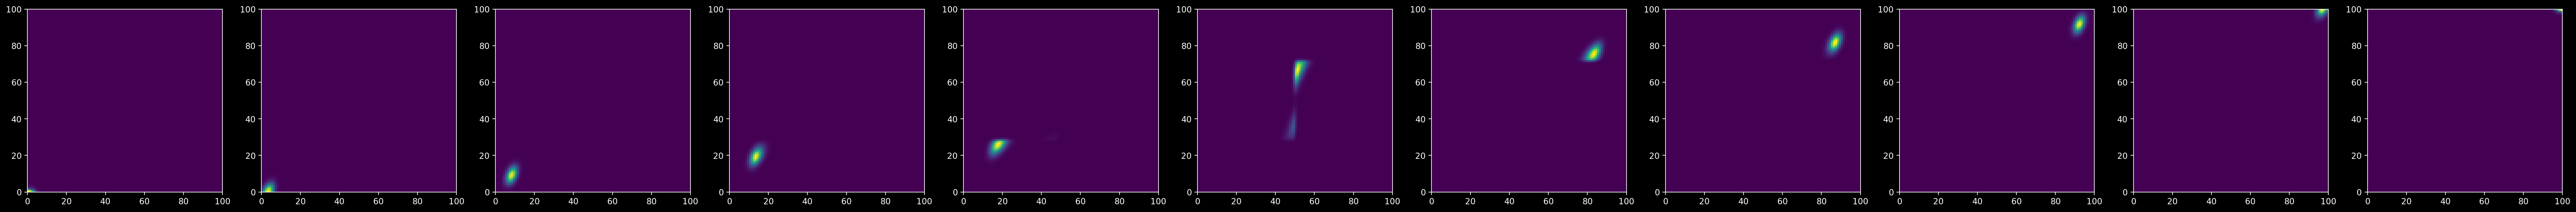

In [59]:
slices = [10,20,30,40,45,50,55,60,70,80,90]
nx, ny = 1, len(slices); figsize=4; fig, ax  = plt.subplots(nx, ny, figsize=(ny * figsize * 1.25, nx * figsize), squeeze=False); axl=ax.ravel(); axc=ax[0,0];  fig.set_label(' ')
for i,j in enumerate(slices):
    axl[i].pcolormesh(K[j,:,:])